# Notebook for generating the ground truth multinomial distributions of LPPMs

In [1]:
# dynamically load the modules and set up the environment
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sys.path.append('../')

import chao
from miller import miller
from empirical import empirical

## 1 Parse the Gowalla dataset

In [2]:
data_path = "../data-LocPrivacy/Gowalla_totalCheckins.txt"
raw_data = pd.read_csv(
    data_path,
    sep="\t",
    header=None,
    names=["user", "timestamp", "latitude", "longitude", "location_id"],
)
raw_data["latitude"] = raw_data["latitude"].astype(float)
raw_data["longitude"] = raw_data["longitude"].astype(float)
print(f"{len(raw_data)=}")
display(raw_data.head())

len(raw_data)=6442892


,user,timestamp,latitude,longitude,location_id
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [3]:
# Data region for the experiment
# Center: (37.755, -122.440)
# Range: +- 1.5 km in latitude and +- 1.5 km in longitude
# 1 degree of latitude and longitude is approximately 111,111 m

lati_center = 37.755
long_center = -122.440
range_meter = 1500
range_degree = range_meter / 111111
lati_min, lati_max = lati_center - range_degree, lati_center + range_degree
long_min, long_max = long_center - range_degree, long_center + range_degree

In [4]:
data_secret = (
    raw_data[
        (raw_data.latitude >= lati_min)
        & (raw_data.latitude <= lati_max)
        & (raw_data.longitude >= long_min)
        & (raw_data.longitude <= long_max)
    ]
    .copy()
    .reset_index()
)[["latitude", "longitude"]]
print(f"{len(data_secret)=}")
display(data_secret.head())

len(data_secret)=8255


,latitude,longitude
0,37.759689,-122.427177
1,37.766406,-122.453012
2,37.764345,-122.438174
3,37.764934,-122.431842
4,37.764388,-122.432671


In [5]:
# Discretization
part_unit_sec = range_degree / 10  # 150 meter
part_thres_sec = np.array([part_unit_sec * i for i in range(1, 20)])
lati_thres_sec = part_thres_sec + lati_min
print(f"{lati_thres_sec=}")
long_thres_sec = part_thres_sec + long_min
print(f"{long_thres_sec=}")


def get_lati_idx(lati, lati_thres_sec):
    return np.sum(lati > lati_thres_sec)


def get_long_idx(long, long_thres_sec):
    return np.sum(long > long_thres_sec)


# test
print(
    f"idx of the lati_center (should be 9): {get_lati_idx(lati_center, lati_thres_sec)}."
)
print(
    f"idx of the long_center (should be 9): {get_long_idx(long_center, long_thres_sec)}."
)

data_secret["idx_lati"] = data_secret["latitude"].apply(
    lambda lati: get_lati_idx(lati, lati_thres_sec)
)
data_secret["idx_long"] = data_secret["longitude"].apply(
    lambda long: get_long_idx(long, long_thres_sec)
)
data_secret["idx"] = list(zip(data_secret.idx_lati, data_secret.idx_long))
data_secret["idx"] = data_secret["idx"].astype("category")
display(data_secret.head())

lati_thres_sec=array([37.74284999, 37.74419999, 37.74554999, 37.74689999, 37.74824999,
       37.74959999, 37.75095   , 37.7523    , 37.75365   , 37.755     ,
       37.75635   , 37.7577    , 37.75905   , 37.76040001, 37.76175001,
       37.76310001, 37.76445001, 37.76580001, 37.76715001])
long_thres_sec=array([-122.45215001, -122.45080001, -122.44945001, -122.44810001,
       -122.44675001, -122.44540001, -122.44405   , -122.4427    ,
       -122.44135   , -122.44      , -122.43865   , -122.4373    ,
       -122.43595   , -122.43459999, -122.43324999, -122.43189999,
       -122.43054999, -122.42919999, -122.42784999])
idx of the lati_center (should be 9): 9.
idx of the long_center (should be 9): 9.


,latitude,longitude,idx_lati,idx_long,idx
0,37.759689,-122.427177,13,19,"(13, 19)"
1,37.766406,-122.453012,18,0,"(18, 0)"
2,37.764345,-122.438174,16,11,"(16, 11)"
3,37.764934,-122.431842,17,16,"(17, 16)"
4,37.764388,-122.432671,16,15,"(16, 15)"


,idx_lati,idx_long,cnt
0,14,13,650
1,13,19,482
2,15,13,458
3,18,17,450
4,7,16,359
...,...,...,...
162,8,16,1
163,8,13,1
164,6,19,1
165,6,17,1


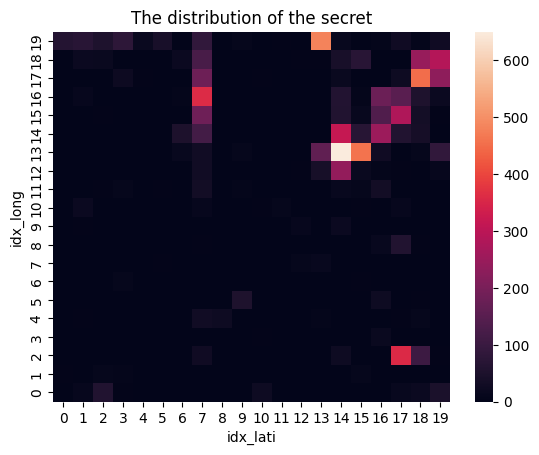

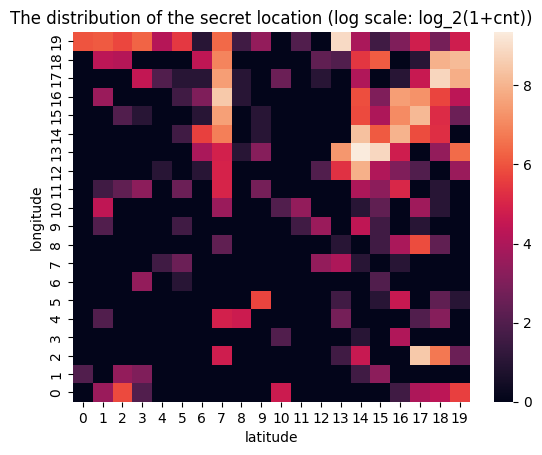

In [9]:
# display the distribution of the secret
cnt_df = (
    data_secret[["idx_lati", "idx_long"]]
    .value_counts()
    .to_frame("cnt")
    .reset_index()
)
display(cnt_df)
cnt_pivot_df = cnt_df.copy()
cnt_pivot_df = cnt_pivot_df.pivot(
    index="idx_long", columns="idx_lati", values="cnt"
)
cnt_pivot_df = cnt_pivot_df.fillna(0)

fig, ax = plt.subplots()
sns.heatmap(cnt_pivot_df, ax=ax)
plt.gca().invert_yaxis()
ax.set_title("The distribution of the secret")
plt.show()

cnt_pivot_df = cnt_df.copy()
cnt_pivot_df["cnt"] = np.log2(cnt_pivot_df["cnt"] + 1)
cnt_pivot_df = cnt_pivot_df.pivot(
    index="idx_long", columns="idx_lati", values="cnt"
)
cnt_pivot_df = cnt_pivot_df.fillna(0)

fig, ax = plt.subplots()
sns.heatmap(cnt_pivot_df, ax=ax)
plt.gca().invert_yaxis()
ax.set_title(
    "The distribution of the secret location (log scale: log_2(1+cnt))"
)
ax.set_xlabel("latitude")
ax.set_ylabel("longitude")
plt.savefig("../figures/heatmap_secret.pdf")
plt.show()

In [17]:
# probability distribution of the secret
prob_sec_df = cnt_df.copy()
prob_sec_df["idx"] = list(zip(prob_sec_df.idx_lati, prob_sec_df.idx_long))
prob_sec_df["prob"] = prob_sec_df["cnt"] / prob_sec_df["cnt"].sum()
prob_sec_df = prob_sec_df[["idx", "prob"]]
prob_sec_df = prob_sec_df.set_index("idx")
prob_sec_df.index = pd.MultiIndex.from_tuples(prob_sec_df.index)
display(prob_sec_df.head())


def entropy(probs):
    probs_nonzero = probs[probs > 0]
    return -np.sum(probs_nonzero * np.log2(probs_nonzero))


print(f"{entropy(prob_sec_df.prob)=}")

,,prob
14,13,0.078740
13,19,0.058389
15,13,0.055482
18,17,0.054512
7,16,0.043489


entropy(prob_sec_df.prob)=5.697259877661799


In [18]:
# construct the secret space
lati_thres_sec = np.array([lati_min] + list(lati_thres_sec) + [lati_max])
long_thres_sec = np.array([long_min] + list(long_thres_sec) + [long_max])
assert len(lati_thres_sec) == 21

lati_sec_centers = (lati_thres_sec[1:] + lati_thres_sec[:-1]) / 2
long_sec_centers = (long_thres_sec[1:] + long_thres_sec[:-1]) / 2
assert (long_sec_centers[9] + long_sec_centers[10]) / 2 == long_center
sec_space_dat = []
for lati_idx in range(20):
    for long_idx in range(20):
        sec_space_dat.append(
            (
                (lati_idx, long_idx),
                lati_sec_centers[lati_idx],
                long_sec_centers[long_idx],
            )
        )
sec_space_df = pd.DataFrame(
    sec_space_dat, columns=["idx", "latitude", "longitude"]
)
sec_space_df = sec_space_df.set_index("idx")
sec_space_df.index = pd.MultiIndex.from_tuples(sec_space_df.index)
display(sec_space_df.head())

probs_sec = []
for sec_idx in sec_space_df.index:
    # if sec_idx not in probs_sec_df.index
    if sec_idx not in prob_sec_df.index:
        probs_sec.append(0)
    else:
        probs_sec.append(prob_sec_df.loc[sec_idx].values[0])

latitude   longitude
0 0  37.742175 -122.452825
  1  37.742175 -122.451475
  2  37.742175 -122.450125
  3  37.742175 -122.448775
  4  37.742175 -122.447425

In [19]:
def distance(lati1, long1, lati2, long2):
    diff_lati = lati1 - lati2
    diff_long = long1 - long2
    diff_lat_meter = diff_lati * 111111
    diff_long_meter = diff_long * 111111
    return np.sqrt(diff_lat_meter**2 + diff_long_meter**2)

## 2 Use planar Geometric mechanism

### Construct the observable space and the joint distribution

In [20]:
part_unit_obs = part_unit_sec / 10  # 15 meter
lati_thres_obs = np.array(
    [lati_center + i * part_unit_obs for i in range(-170, 171)]
)
long_thres_obs = np.array(
    [long_center + i * part_unit_obs for i in range(-170, 171)]
)
assert len(lati_thres_obs) == 341

lati_obs_centers = (lati_thres_obs[0:340] + lati_thres_obs[1:341]) / 2
long_obs_centers = (long_thres_obs[0:340] + long_thres_obs[1:341]) / 2
assert (lati_obs_centers[169] + lati_obs_centers[170]) / 2 == lati_center
obs_space_dat = []
for lati_idx in range(340):
    for long_idx in range(340):
        obs_space_dat.append(
            (
                (lati_idx, long_idx),
                lati_obs_centers[lati_idx],
                long_obs_centers[long_idx],
            )
        )
obs_space_df = pd.DataFrame(
    obs_space_dat, columns=["idx", "latitude", "longitude"]
)
obs_space_df = obs_space_df.set_index("idx")
obs_space_df.index = pd.MultiIndex.from_tuples(obs_space_df.index)
display(obs_space_df.head())

latitude   longitude
0 0  37.732117 -122.462883
  1  37.732117 -122.462748
  2  37.732117 -122.462613
  3  37.732117 -122.462478
  4  37.732117 -122.462343

latitude   longitude type
0 0  37.732117 -122.462883  obs
  1  37.732117 -122.462748  obs
  2  37.732117 -122.462613  obs
  3  37.732117 -122.462478  obs
  4  37.732117 -122.462343  obs

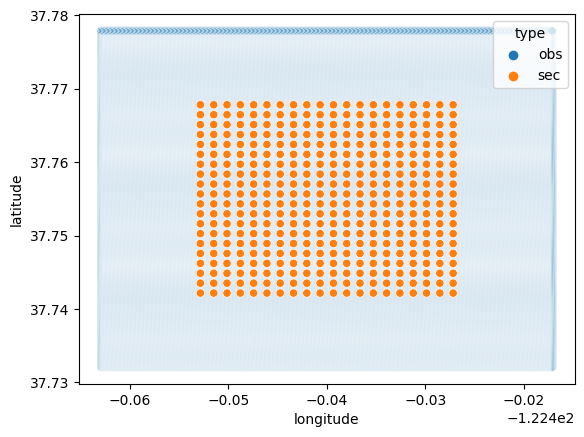

In [21]:
obs_space_df_for_merge = obs_space_df.copy()
obs_space_df_for_merge["type"] = "obs"
sec_space_df_for_merge = sec_space_df.copy()
sec_space_df_for_merge["type"] = "sec"
space_df = pd.concat([obs_space_df_for_merge, sec_space_df_for_merge])
display(space_df.head())

# plot the dots of the secret and the observation space
fig, ax = plt.subplots()
sns.scatterplot(data=space_df, x="longitude", y="latitude", ax=ax, hue="type")
plt.show()

In [22]:
def geo_mechanism(idx_sec, idx_obs, noise_level):
    lati_sec, long_sec = sec_space_df.loc[idx_sec][
        ["latitude", "longitude"]
    ].values
    lati_obs, long_obs = obs_space_df.loc[idx_obs][
        ["latitude", "longitude"]
    ].values
    return np.exp(
        -np.log(noise_level)
        * distance(lati_sec, long_sec, lati_obs, long_obs)
        / 100
    )

#### show how the mechanism works

lati_sec=37.754324999325, long_sec=-122.44067500067499


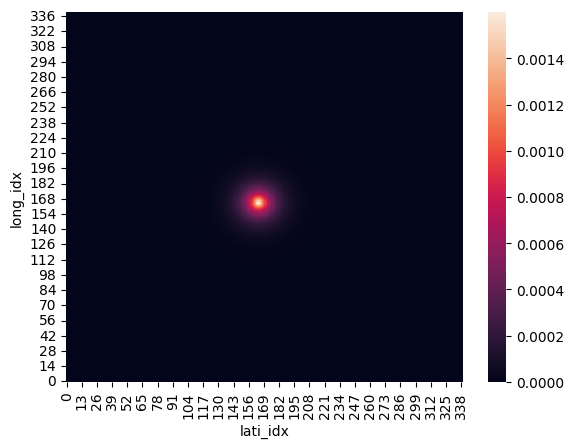

In [43]:
noise_level = 2
idx_sec = (9, 9)
lati_sec, long_sec = sec_space_df.loc[idx_sec][
    ["latitude", "longitude"]
].values
print(f"{lati_sec=}, {long_sec=}")
probs = []
num_idx_obs = len(obs_space_df)
for cnt, idx_obs in enumerate(obs_space_df.index):
    print(f"{cnt}/{num_idx_obs}: {idx_obs=}", end="\r", flush=True)
    lati_obs, long_obs = obs_space_df.loc[idx_obs][
        ["latitude", "longitude"]
    ].values
    probs.append((idx_obs, geo_mechanism(idx_sec, idx_obs, noise_level)))
probs_df = pd.DataFrame(probs, columns=["idx_obs", "prob"])
probs_df["prob"] = probs_df["prob"] / probs_df["prob"].sum()
probs_df["lati_idx"] = probs_df["idx_obs"].apply(
    lambda idx_obs: int(idx_obs[0])
)
probs_df["long_idx"] = probs_df["idx_obs"].apply(
    lambda idx_obs: int(idx_obs[1])
)
probs_pivot_df = probs_df[["lati_idx", "long_idx", "prob"]].pivot(
    index="long_idx", columns="lati_idx", values="prob"
)
fig, ax = plt.subplots()
sns.heatmap(probs_pivot_df, ax=ax)
plt.gca().invert_yaxis()
plt.show()

In [23]:
# fast computation
# \*_secs: each len(obs_space_df) elements in lati_secs and long_secs are the
# same
lati_secs = np.repeat(sec_space_df["latitude"].tolist(), len(obs_space_df))
long_secs = np.repeat(sec_space_df["longitude"].tolist(), len(obs_space_df))
# \*_obss: len(obs_space_df) elements are repeated len(sec_space_df) times
lati_obss = np.array(obs_space_df["latitude"].tolist() * len(sec_space_df))
long_obss = np.array(obs_space_df["longitude"].tolist() * len(sec_space_df))
distances = distance(lati_secs, long_secs, lati_obss, long_obss)


def get_probs(distances, noise_level, probs_sec):
    probs_unnormalized = np.exp(-np.log(noise_level) * distances / 100)
    # normalize: split the probs by num of sec_space, sum them, and divide the
    # probs by the sum
    sum_per_sec = np.array(
        np.array_split(probs_unnormalized, len(sec_space_df))
    ).sum(axis=1)
    assert len(sum_per_sec) == len(sec_space_df)
    probs_normalized_per_sec = probs_unnormalized / np.repeat(
        sum_per_sec, len(obs_space_df)
    )
    assert np.abs(sum(probs_normalized_per_sec) - len(sec_space_df)) < 1e-8
    probs = probs_normalized_per_sec * np.repeat(probs_sec, len(obs_space_df))
    assert np.abs(1 - sum(probs)) < 1e-8
    probs = probs / sum(probs)
    return probs

#### Distribution with the noise level = 2

In [24]:
noise_level = 2
probs_2 = get_probs(distances, noise_level, probs_sec)

In [25]:
prob_idxs = np.hstack(
    (
        np.repeat(
            np.array(sec_space_df.index.tolist()), len(obs_space_df), axis=0
        ),
        np.array(obs_space_df.index.tolist() * len(sec_space_df)),
    )
)

In [26]:
prob_df = pd.DataFrame(
    {
        "lati_sec": prob_idxs[:, 0],
        "long_sec": prob_idxs[:, 1],
        "lati_obs": prob_idxs[:, 2],
        "long_obs": prob_idxs[:, 3],
        "prob": probs_2,
    }
)
prob_df = prob_df.set_index(
    ["lati_sec", "long_sec", "lati_obs", "long_obs"]
)
prob_df.head()

prob
lati_sec long_sec lati_obs long_obs      
0        0        0        0          0.0
                           1          0.0
                           2          0.0
                           3          0.0
                           4          0.0

In [27]:
display(prob_df.loc[(14, 13, 14, 13)])
print(f"{len(prob_df)=}")

prob    4.096096e-17
Name: (14, 13, 14, 13), dtype: float64

len(prob_df)=46240000


#### Entropy and the mutual information of the joint distribution

In [28]:
probs_sec = prob_df.groupby(["lati_sec", "long_sec"]).prob.sum()
ent_sec = entropy(probs_sec)
print(f"{ent_sec=}")

probs_obs = prob_df.groupby(["lati_obs", "long_obs"]).prob.sum()
ent_obs = entropy(probs_obs)
print(f"{ent_obs=}")

ent_joint = entropy(prob_df.prob)
print(f"{ent_joint=}")

mi = ent_sec + ent_obs - ent_joint
print(f"{mi=}")

ent_sec=5.697259877699065
ent_obs=14.677718031114091
ent_joint=17.763118483311636
mi=2.611859425501521


#### Save the joint distribution

In [29]:
save_path = "../data-LocPrivacy/prob_df-PG2.csv"
prob_df.to_csv(save_path)

## 3 Use the Blahut-Arimoto mechanism

### Construct the observable space and the joint distribution

In [36]:
# 340 X 340
part_unit_obs = part_unit_sec / 10  # 15 meter
lati_thres_obs = np.array(
    [lati_center + i * part_unit_obs for i in range(-170, 171)]
)
long_thres_obs = np.array(
    [long_center + i * part_unit_obs for i in range(-170, 171)]
)
assert len(lati_thres_obs) == 341

lati_obs_centers = (lati_thres_obs[0:340] + lati_thres_obs[1:341]) / 2
long_obs_centers = (long_thres_obs[0:340] + long_thres_obs[1:341]) / 2
assert (lati_obs_centers[169] + lati_obs_centers[170]) / 2 == lati_center
obs_space_dat = []
for lati_idx in range(340):
    for long_idx in range(340):
        obs_space_dat.append(
            (
                (lati_idx, long_idx),
                lati_obs_centers[lati_idx],
                long_obs_centers[long_idx],
            )
        )
obs_space_df = pd.DataFrame(
    obs_space_dat, columns=["idx", "latitude", "longitude"]
)
obs_space_df = obs_space_df.set_index("idx")
obs_space_df.index = pd.MultiIndex.from_tuples(obs_space_df.index)
display(obs_space_df.head())

latitude   longitude
0 0  37.732117 -122.462883
  1  37.732117 -122.462748
  2  37.732117 -122.462613
  3  37.732117 -122.462478
  4  37.732117 -122.462343

latitude   longitude type
0 0  37.732117 -122.462883  obs
  1  37.732117 -122.462748  obs
  2  37.732117 -122.462613  obs
  3  37.732117 -122.462478  obs
  4  37.732117 -122.462343  obs

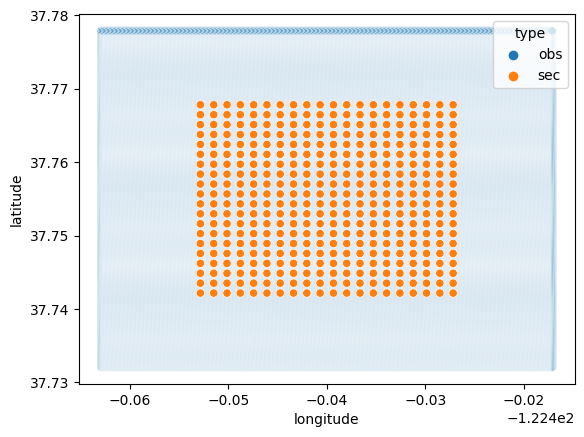

In [37]:
obs_space_df_for_merge = obs_space_df.copy()
obs_space_df_for_merge["type"] = "obs"
sec_space_df_for_merge = sec_space_df.copy()
sec_space_df_for_merge["type"] = "sec"
space_df = pd.concat([obs_space_df_for_merge, sec_space_df_for_merge])
display(space_df.head())

# plot the dots of the secret and the observation space
fig, ax = plt.subplots()
sns.scatterplot(data=space_df, x="longitude", y="latitude", ax=ax, hue="type")
plt.show()

In [38]:
# fast computation
# \*_secs: each len(obs_space_df) elements in lati_secs and long_secs are the
# same
lati_secs = np.repeat(sec_space_df["latitude"].tolist(), len(obs_space_df))
long_secs = np.repeat(sec_space_df["longitude"].tolist(), len(obs_space_df))
# \*_obss: len(obs_space_df) elements are repeated len(sec_space_df) times
lati_obss = np.array(obs_space_df["latitude"].tolist() * len(sec_space_df))
long_obss = np.array(obs_space_df["longitude"].tolist() * len(sec_space_df))
distances = distance(lati_secs, long_secs, lati_obss, long_obss)

prob_sec_df = cnt_df.copy()
prob_sec_df["idx"] = list(zip(prob_sec_df.idx_lati, prob_sec_df.idx_long))
prob_sec_df["prob"] = prob_sec_df["cnt"] / prob_sec_df["cnt"].sum()
prob_sec_df = prob_sec_df[["idx", "prob"]]
prob_sec_df = prob_sec_df.set_index("idx")
prob_sec_df.index = pd.MultiIndex.from_tuples(prob_sec_df.index)
probs_sec = []
for sec_idx in sec_space_df.index:
    # if sec_idx not in probs_sec_df.index
    if sec_idx not in prob_sec_df.index:
        probs_sec.append(0)
    else:
        probs_sec.append(prob_sec_df.loc[sec_idx].values[0])
probs_sec = np.array(probs_sec)

In [40]:
def get_probs(distances, probs_sec, b, end_thres, max_iter=-1):
    pso = np.ones((len(sec_space_df), len(obs_space_df))) / len(obs_space_df)

    iter_idx = 0
    while True:
        iter_idx += 1
        prev_pso = pso.copy()
        # row-wise multiplication between pso and probs_sec
        po = np.sum(
            pso
            * np.repeat(probs_sec, len(obs_space_df)).reshape(
                -1, len(obs_space_df)
            ),
            axis=0,
        )
        assert len(po) == len(obs_space_df)
        po = po / np.sum(po)
        po_repeated = np.repeat(
            po.reshape(1, -1), len(sec_space_df), axis=0
        ).flatten()
        pso_flatten = np.exp(-b * distances) * po_repeated
        pso = pso_flatten.reshape(len(sec_space_df), len(obs_space_df))
        pso /= np.sum(pso, axis=1)[:, np.newaxis]
        assert np.isclose(np.sum(pso[0]), 1.0)
        if np.sum(np.abs(pso - prev_pso)) < end_thres:
            break
        if max_iter > 0 and iter_idx >= max_iter:
            break
        if iter_idx % 10 == 0:
            sum_diff = np.sum(np.abs(prev_pso - pso))
            pso_norm = pso * np.repeat(probs_sec, len(obs_space_df)).reshape(
                -1, len(obs_space_df)
            )
            pso_norm = pso_norm / np.sum(pso_norm)
            ps = np.array(probs_sec)
            po = np.sum(pso_norm, axis=0)
            mi = (
                entropy(po[po > 0])
                + entropy(ps[ps > 0])
                - entropy(pso_norm[pso_norm > 0].flatten())
            )
            print(
                f"iter {iter_idx}: sum_diff={sum_diff:.6f}, mi={mi:.6f}",
                flush=True,
            )
    return pso

In [41]:
pso = get_probs(distances, probs_sec, 0.01, end_thres=1, max_iter=100)

iter 10: sum_diff=45.165432, mi=3.139028
iter 20: sum_diff=21.675434, mi=3.163294
iter 30: sum_diff=11.721785, mi=3.185407
iter 40: sum_diff=7.017582, mi=3.199397
iter 50: sum_diff=4.791019, mi=3.207488
iter 60: sum_diff=3.597426, mi=3.212588
iter 70: sum_diff=2.935349, mi=3.215865
iter 80: sum_diff=2.514265, mi=3.217922
iter 90: sum_diff=2.211259, mi=3.219147


In [43]:
prob_idxs = np.hstack(
    (
        np.repeat(
            np.array(sec_space_df.index.tolist()), len(obs_space_df), axis=0
        ),
        np.array(obs_space_df.index.tolist() * len(sec_space_df)),
    )
)
prob_df = pd.DataFrame(
    {
        "lati_sec": prob_idxs[:, 0],
        "long_sec": prob_idxs[:, 1],
        "lati_obs": prob_idxs[:, 2],
        "long_obs": prob_idxs[:, 3],
        "prob": np.concatenate(
            [pso[i] * probs_sec[i] for i in range(len(probs_sec))]
        ),
    }
)
prob_df = prob_df.set_index(["lati_sec", "long_sec", "lati_obs", "long_obs"])
prob_df.head()

prob
lati_sec long_sec lati_obs long_obs      
0        0        0        0          0.0
                           1          0.0
                           2          0.0
                           3          0.0
                           4          0.0

#### Save the joint distribution

In [44]:
save_path = "../data-LocPrivacy/prob_df-Opt.csv"
prob_df.to_csv(save_path)